In [15]:
import numpy as np
from scipy.linalg import solve_banded
import matplotlib.pyplot as plt

## EX 1

On considère l’application
$$
u \in L^2(0,T) ;\longmapsto; y_u \in L^2(0,T;H^1(0,L)),
$$
où $y_u$ est la solution de l’équation de la chaleur avec contrôle de Neumann au bord $x=L$.
Le problème d’état étant linéaire par rapport au contrôle $u$ et bien posé, l’opérateur
$$
u \longmapsto y_u
$$
est linéaire et continu.

La fonctionnelle coût
$$
J(u)
= \frac12 \int_0^T \bigl(y_u(t,L)-z_d(t)\bigr)^2,dt

* \frac{\varepsilon}{2}\int_0^T u(t)^2,dt
$$
  est donc la somme de termes quadratiques composés avec des opérateurs linéaires continus.
  Elle est par conséquent **Fréchet-différentiable sur $L^2(0,T)$**.

### Calcul du gradient par la méthode de l’adjoint

Soit $v \in L^2(0,T)$ une variation admissible du contrôle, et $\delta y$ la variation correspondante de l’état.
On a
$$
\delta J(u;v)
= \int_0^T \bigl(y_u(t,L)-z_d(t)\bigr),\delta y(t,L),dt

* \varepsilon \int_0^T u(t)v(t),dt.
$$
Afin d’éliminer la dépendance en $\delta y$, on introduit l’état adjoint $p(t,x)$ solution du problème rétrograde :
$$
\begin{cases}
\partial_t p + \partial_{xx} p = 0, & (t,x)\in(0,T)\times(0,L),\\
p(T,x)=0, & x\in(0,L),\\
p(t,0)=0, & t\in(0,T),\\
\partial_x p(t,L)= y_u(t,L)-z_d(t), & t\in(0,T).
\end{cases}
$$
En utilisant des intégrations par parties et les formules de Green, on obtient
$$
\delta J(u;v)
= \int_0^T \bigl(p(t,L)+\varepsilon u(t)\bigr),v(t),dt.
$$
Ainsi, le gradient de la fonctionnelle coût est donné par
$$
\boxed{
\nabla J(u)(t) = p(t,L) + \varepsilon u(t), \quad \text{p.p. } t\in(0,T).
}
$$

## EX 2

In [16]:
def solve_heat_equation(L, T, Nx, Nt, u):
    dx = L / Nx
    dt = T / Nt
    lam = dt / dx**2

    x = np.linspace(0, L, Nx+1)
    t = np.linspace(0, T, Nt+1)

    Y = np.zeros((Nt+1, Nx+1))

    main = np.zeros(Nx)
    lower = np.zeros(Nx-1)
    upper = np.zeros(Nx-1)

    main[:] = 1 + 2*lam
    lower[:] = -lam
    upper[:] = -lam

    main[-1] = 1 + lam

    ab = np.zeros((3, Nx))
    ab[0, 1:] = upper
    ab[1, :]  = main
    ab[2, :-1] = lower

    for k in range(1, Nt+1):
        rhs = Y[k-1, 1:].copy()
        rhs[-1] += dt/dx * u[k]
        Y[k, 1:] = solve_banded((1, 1), ab, rhs)

    return x, t, Y

In [17]:
L, T = 1.0, 0.5
Nx, Nt = 50, 200

u = np.zeros(Nt+1)

x, t, Y = solve_heat_equation(L, T, Nx, Nt, u)

print("Max |y| =", np.max(np.abs(Y)))


Max |y| = 0.0


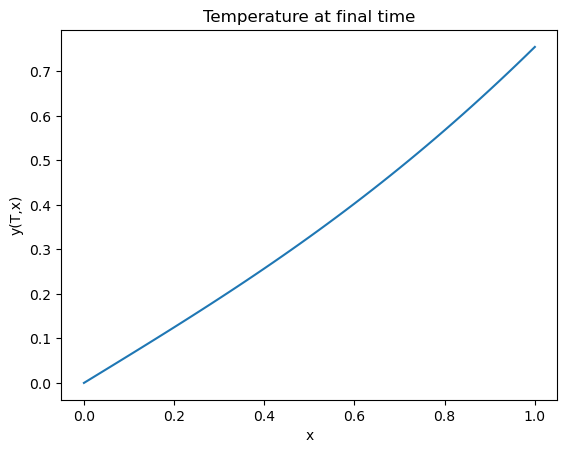

In [18]:
u = np.ones(Nt+1)

x, t, Y = solve_heat_equation(L, T, Nx, Nt, u)

plt.plot(x, Y[-1])
plt.xlabel("x")
plt.ylabel("y(T,x)")
plt.title("Temperature at final time")
plt.show()


## EX 3

In [19]:
def solve_adjoint(L, T, Nx, Nt, yL, zd):
    g = (yL[::-1] - zd[::-1])

    x, t, Q = solve_heat_equation(L, T, Nx, Nt, g)

    P = Q[::-1]

    return P[:, -1]

In [20]:
def compute_gradient(L, T, Nx, Nt, u, zd, eps):
    _, _, Y = solve_heat_equation(L, T, Nx, Nt, u)
    yL = Y[:, -1]

    pL = solve_adjoint(L, T, Nx, Nt, yL, zd)

    grad = pL + eps * u
    return grad

In [21]:
L, T = 1.0, 0.5
Nx, Nt = 50, 200
eps = 1e-2

u = np.sin(np.linspace(0, T, Nt+1))
zd = np.zeros(Nt+1)

grad = compute_gradient(L, T, Nx, Nt, u, zd, eps)

print("Gradient norm:", np.linalg.norm(grad))

Gradient norm: 0.9752760366486729


## EX 4

In [22]:
def cost_function(yL, u, zd, eps, dt):
    return 0.5 * dt * np.sum((yL - zd)**2) + 0.5 * eps * dt * np.sum(u**2)

In [23]:
def optimal_control(
    L, T, Nx, Nt,
    zd, eps,
    alpha=0.3,
    max_iter=100,
    tol=1e-6,
    u0=None
):
    dt = T / Nt

    if u0 is None:
        u = np.zeros(Nt+1)
    else:
        u = u0.copy()

    Jhist = []

    for it in range(max_iter):
        _, _, Y = solve_heat_equation(L, T, Nx, Nt, u)
        yL = Y[:, -1]

        J = cost_function(yL, u, zd, eps, dt)
        Jhist.append(J)

        grad = compute_gradient(L, T, Nx, Nt, u, zd, eps)
        grad_norm = np.linalg.norm(grad)

        print(f"Iter {it:3d} | J = {J:.3e} | ||grad|| = {grad_norm:.3e}")

        if grad_norm < tol:
            break

        u -= alpha * grad

    return u, np.array(Jhist)

### test 1

Iter   0 | J = 0.000e+00 | ||grad|| = 0.000e+00


/var/folders/53/dz3rwmgx46b2y6jyc15z61r00000gn/T/ipykernel_23152/2047139529.py:15: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


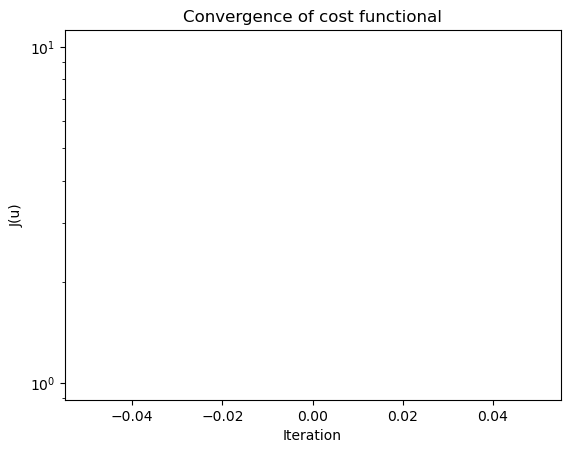

In [24]:
L, T = 1.0, 0.5
Nx, Nt = 50, 200
eps = 1e-2

zd = np.zeros(Nt+1)

u_opt, Jhist = optimal_control(
    L, T, Nx, Nt,
    zd, eps,
    alpha=0.5,
    max_iter=50
)
plt.figure()
plt.plot(Jhist)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("J(u)")
plt.title("Convergence of cost functional")
plt.show()

### test 2

Iter   0 | J = 1.250e-01 | ||grad|| = 5.410e+00
Iter   1 | J = 1.042e-01 | ||grad|| = 4.888e+00
Iter   2 | J = 8.725e-02 | ||grad|| = 4.419e+00
Iter   3 | J = 7.339e-02 | ||grad|| = 3.996e+00
Iter   4 | J = 6.206e-02 | ||grad|| = 3.616e+00
Iter   5 | J = 5.278e-02 | ||grad|| = 3.274e+00
Iter   6 | J = 4.517e-02 | ||grad|| = 2.967e+00
Iter   7 | J = 3.892e-02 | ||grad|| = 2.690e+00
Iter   8 | J = 3.379e-02 | ||grad|| = 2.442e+00
Iter   9 | J = 2.955e-02 | ||grad|| = 2.219e+00
Iter  10 | J = 2.606e-02 | ||grad|| = 2.019e+00
Iter  11 | J = 2.316e-02 | ||grad|| = 1.839e+00
Iter  12 | J = 2.076e-02 | ||grad|| = 1.678e+00
Iter  13 | J = 1.876e-02 | ||grad|| = 1.533e+00
Iter  14 | J = 1.708e-02 | ||grad|| = 1.404e+00
Iter  15 | J = 1.568e-02 | ||grad|| = 1.287e+00
Iter  16 | J = 1.450e-02 | ||grad|| = 1.183e+00
Iter  17 | J = 1.350e-02 | ||grad|| = 1.090e+00
Iter  18 | J = 1.265e-02 | ||grad|| = 1.007e+00
Iter  19 | J = 1.192e-02 | ||grad|| = 9.320e-01
Iter  20 | J = 1.130e-02 | ||grad|| = 8.

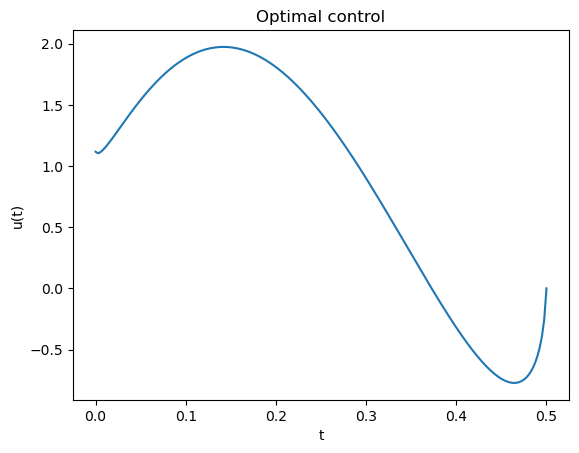

In [25]:
t = np.linspace(0, T, Nt+1)
zd = np.sin(2*np.pi*t)

u_opt, Jhist = optimal_control(
    L, T, Nx, Nt,
    zd, eps,
    alpha=0.3,
    max_iter=80
)
plt.figure()
plt.plot(t, u_opt)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Optimal control")
plt.show()

## EX 5

In [26]:
def run_experiment(L, T, Nx, Nt, eps, zd_fun, alpha, max_iter=80):
    t = np.linspace(0, T, Nt+1)
    zd = zd_fun(t)

    u_opt, Jhist = optimal_control(
        L, T, Nx, Nt,
        zd, eps,
        alpha=alpha,
        max_iter=max_iter,
        tol=1e-6
    )

    _, _, Y = solve_heat_equation(L, T, Nx, Nt, u_opt)
    yL = Y[:, -1]

    return t, zd, u_opt, yL, np.array(Jhist)

def plot_result(t, zd, u, yL, Jhist, title=""):
    plt.figure()
    plt.plot(Jhist)
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("J(u)")
    plt.title("Convergence " + title)
    plt.show()

    plt.figure()
    plt.plot(t, zd, label="z_d(t)")
    plt.plot(t, yL, label="y(t,L)")
    plt.xlabel("t")
    plt.title("Tracking at boundary " + title)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(t, u)
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.title("Optimal control " + title)
    plt.show()


In [27]:
def zd_zero(t):
    return np.zeros_like(t)

def zd_smooth(t):
    return np.sin(2*np.pi*t/t[-1])

def zd_highfreq(t):
    return np.sin(10*np.pi*t/t[-1])


Iter   0 | J = 1.250e-01 | ||grad|| = 3.952e+00
Iter   1 | J = 1.061e-01 | ||grad|| = 3.249e+00
Iter   2 | J = 9.326e-02 | ||grad|| = 2.693e+00
Iter   3 | J = 8.444e-02 | ||grad|| = 2.244e+00
Iter   4 | J = 7.831e-02 | ||grad|| = 1.876e+00
Iter   5 | J = 7.402e-02 | ||grad|| = 1.573e+00
Iter   6 | J = 7.100e-02 | ||grad|| = 1.322e+00
Iter   7 | J = 6.887e-02 | ||grad|| = 1.112e+00
Iter   8 | J = 6.737e-02 | ||grad|| = 9.366e-01
Iter   9 | J = 6.630e-02 | ||grad|| = 7.897e-01
Iter  10 | J = 6.554e-02 | ||grad|| = 6.665e-01
Iter  11 | J = 6.500e-02 | ||grad|| = 5.631e-01
Iter  12 | J = 6.462e-02 | ||grad|| = 4.762e-01
Iter  13 | J = 6.434e-02 | ||grad|| = 4.032e-01
Iter  14 | J = 6.415e-02 | ||grad|| = 3.417e-01
Iter  15 | J = 6.400e-02 | ||grad|| = 2.899e-01
Iter  16 | J = 6.390e-02 | ||grad|| = 2.462e-01
Iter  17 | J = 6.383e-02 | ||grad|| = 2.094e-01
Iter  18 | J = 6.378e-02 | ||grad|| = 1.783e-01
Iter  19 | J = 6.374e-02 | ||grad|| = 1.520e-01
Iter  20 | J = 6.371e-02 | ||grad|| = 1.

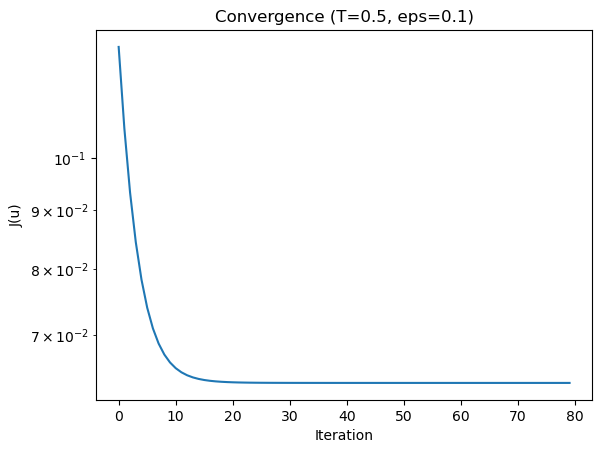

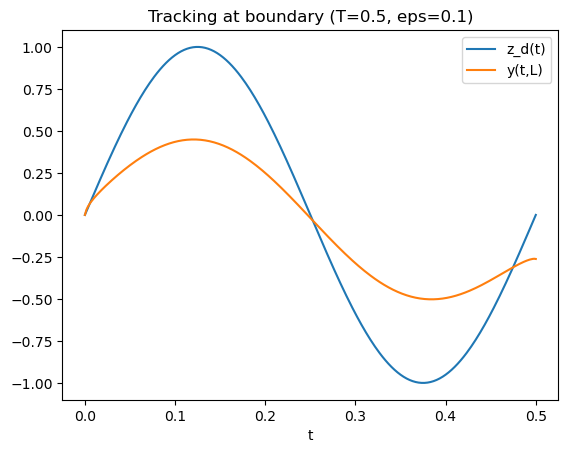

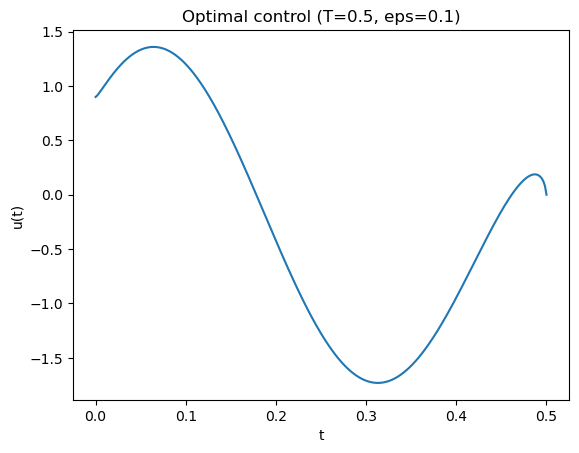

Iter   0 | J = 1.250e-01 | ||grad|| = 3.952e+00
Iter   1 | J = 1.149e-01 | ||grad|| = 3.741e+00
Iter   2 | J = 1.058e-01 | ||grad|| = 3.546e+00
Iter   3 | J = 9.767e-02 | ||grad|| = 3.367e+00
Iter   4 | J = 9.031e-02 | ||grad|| = 3.201e+00
Iter   5 | J = 8.367e-02 | ||grad|| = 3.046e+00
Iter   6 | J = 7.765e-02 | ||grad|| = 2.901e+00
Iter   7 | J = 7.219e-02 | ||grad|| = 2.766e+00
Iter   8 | J = 6.723e-02 | ||grad|| = 2.638e+00
Iter   9 | J = 6.271e-02 | ||grad|| = 2.518e+00
Iter  10 | J = 5.859e-02 | ||grad|| = 2.404e+00
Iter  11 | J = 5.484e-02 | ||grad|| = 2.297e+00
Iter  12 | J = 5.142e-02 | ||grad|| = 2.195e+00
Iter  13 | J = 4.829e-02 | ||grad|| = 2.098e+00
Iter  14 | J = 4.543e-02 | ||grad|| = 2.007e+00
Iter  15 | J = 4.282e-02 | ||grad|| = 1.919e+00
Iter  16 | J = 4.043e-02 | ||grad|| = 1.837e+00
Iter  17 | J = 3.824e-02 | ||grad|| = 1.758e+00
Iter  18 | J = 3.623e-02 | ||grad|| = 1.682e+00
Iter  19 | J = 3.439e-02 | ||grad|| = 1.611e+00
Iter  20 | J = 3.271e-02 | ||grad|| = 1.

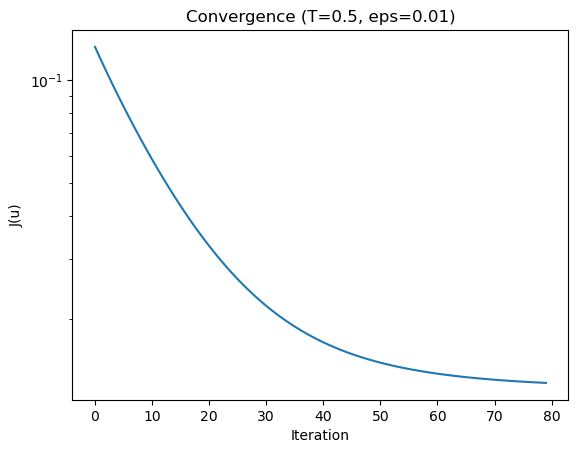

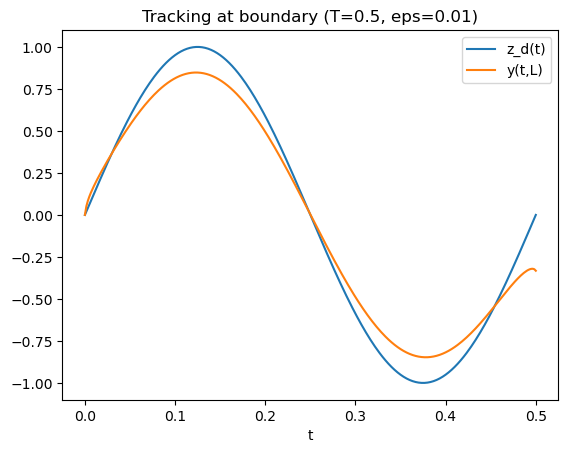

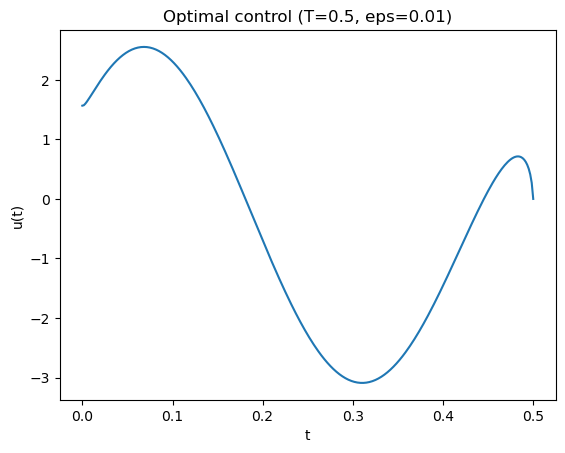

Iter   0 | J = 1.250e-01 | ||grad|| = 3.952e+00
Iter   1 | J = 1.211e-01 | ||grad|| = 3.878e+00
Iter   2 | J = 1.174e-01 | ||grad|| = 3.806e+00
Iter   3 | J = 1.138e-01 | ||grad|| = 3.736e+00
Iter   4 | J = 1.104e-01 | ||grad|| = 3.668e+00
Iter   5 | J = 1.071e-01 | ||grad|| = 3.602e+00
Iter   6 | J = 1.039e-01 | ||grad|| = 3.538e+00
Iter   7 | J = 1.008e-01 | ||grad|| = 3.475e+00
Iter   8 | J = 9.778e-02 | ||grad|| = 3.415e+00
Iter   9 | J = 9.489e-02 | ||grad|| = 3.356e+00
Iter  10 | J = 9.211e-02 | ||grad|| = 3.298e+00
Iter  11 | J = 8.942e-02 | ||grad|| = 3.242e+00
Iter  12 | J = 8.682e-02 | ||grad|| = 3.187e+00
Iter  13 | J = 8.431e-02 | ||grad|| = 3.134e+00
Iter  14 | J = 8.188e-02 | ||grad|| = 3.082e+00
Iter  15 | J = 7.954e-02 | ||grad|| = 3.031e+00
Iter  16 | J = 7.727e-02 | ||grad|| = 2.981e+00
Iter  17 | J = 7.507e-02 | ||grad|| = 2.932e+00
Iter  18 | J = 7.294e-02 | ||grad|| = 2.885e+00
Iter  19 | J = 7.089e-02 | ||grad|| = 2.838e+00
Iter  20 | J = 6.890e-02 | ||grad|| = 2.

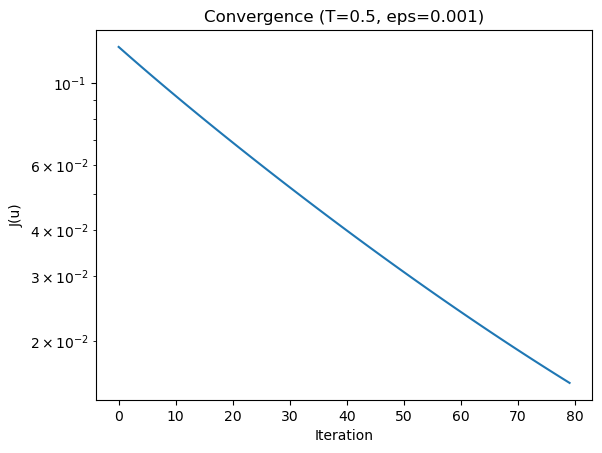

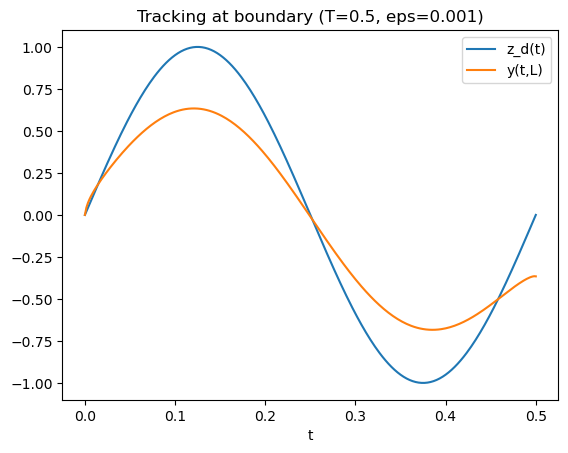

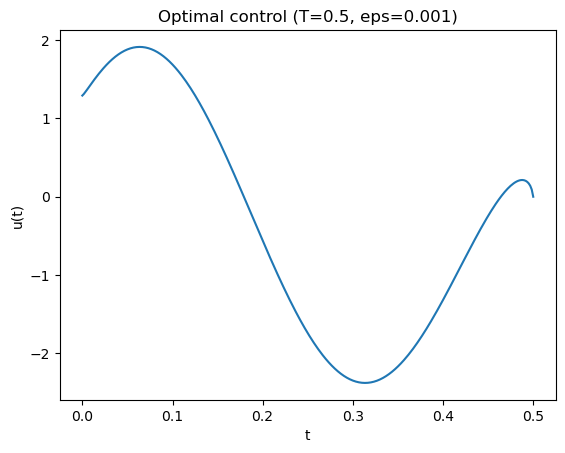

In [28]:
L = 1.0
Nx, Nt = 60, 300

# --- Case A: test eps ---
T = 0.5
for eps, alpha in [(1e-1, 0.8), (1e-2, 0.4), (1e-3, 0.15)]:
    t, zd, u, yL, Jhist = run_experiment(L, T, Nx, Nt, eps, zd_smooth, alpha, max_iter=80)
    plot_result(t, zd, u, yL, Jhist, title=f"(T={T}, eps={eps})")


Iter   0 | J = 5.000e-02 | ||grad|| = 2.446e+00
Iter   1 | J = 4.804e-02 | ||grad|| = 2.374e+00
Iter   2 | J = 4.619e-02 | ||grad|| = 2.305e+00
Iter   3 | J = 4.445e-02 | ||grad|| = 2.239e+00
Iter   4 | J = 4.280e-02 | ||grad|| = 2.176e+00
Iter   5 | J = 4.125e-02 | ||grad|| = 2.116e+00
Iter   6 | J = 3.978e-02 | ||grad|| = 2.058e+00
Iter   7 | J = 3.839e-02 | ||grad|| = 2.002e+00
Iter   8 | J = 3.708e-02 | ||grad|| = 1.948e+00
Iter   9 | J = 3.583e-02 | ||grad|| = 1.897e+00
Iter  10 | J = 3.465e-02 | ||grad|| = 1.847e+00
Iter  11 | J = 3.353e-02 | ||grad|| = 1.799e+00
Iter  12 | J = 3.247e-02 | ||grad|| = 1.753e+00
Iter  13 | J = 3.147e-02 | ||grad|| = 1.708e+00
Iter  14 | J = 3.051e-02 | ||grad|| = 1.664e+00
Iter  15 | J = 2.960e-02 | ||grad|| = 1.622e+00
Iter  16 | J = 2.874e-02 | ||grad|| = 1.582e+00
Iter  17 | J = 2.792e-02 | ||grad|| = 1.542e+00
Iter  18 | J = 2.714e-02 | ||grad|| = 1.504e+00
Iter  19 | J = 2.639e-02 | ||grad|| = 1.467e+00
Iter  20 | J = 2.569e-02 | ||grad|| = 1.

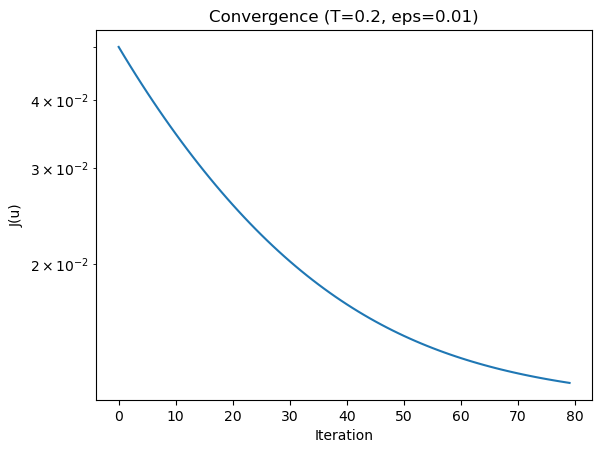

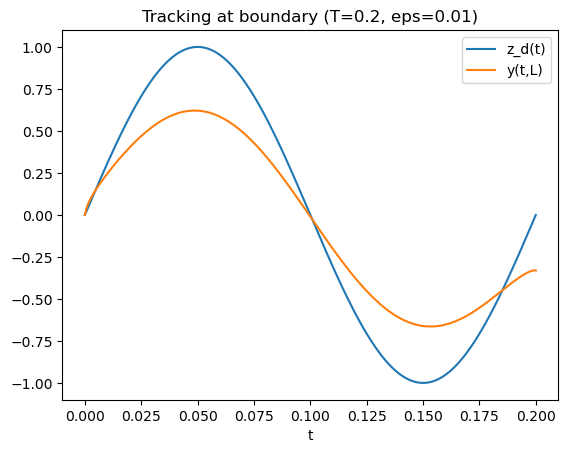

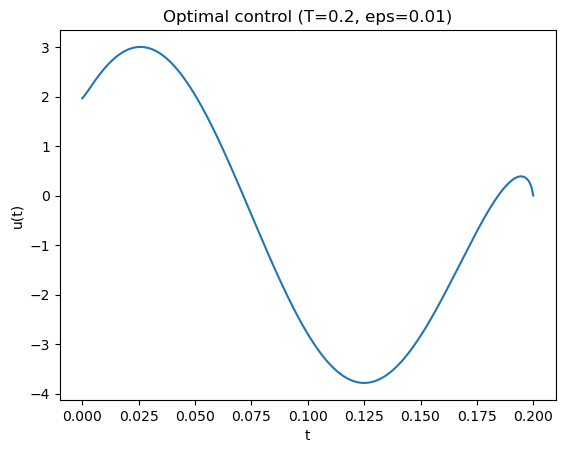

Iter   0 | J = 1.250e-01 | ||grad|| = 3.952e+00
Iter   1 | J = 1.149e-01 | ||grad|| = 3.741e+00
Iter   2 | J = 1.058e-01 | ||grad|| = 3.546e+00
Iter   3 | J = 9.767e-02 | ||grad|| = 3.367e+00
Iter   4 | J = 9.031e-02 | ||grad|| = 3.201e+00
Iter   5 | J = 8.367e-02 | ||grad|| = 3.046e+00
Iter   6 | J = 7.765e-02 | ||grad|| = 2.901e+00
Iter   7 | J = 7.219e-02 | ||grad|| = 2.766e+00
Iter   8 | J = 6.723e-02 | ||grad|| = 2.638e+00
Iter   9 | J = 6.271e-02 | ||grad|| = 2.518e+00
Iter  10 | J = 5.859e-02 | ||grad|| = 2.404e+00
Iter  11 | J = 5.484e-02 | ||grad|| = 2.297e+00
Iter  12 | J = 5.142e-02 | ||grad|| = 2.195e+00
Iter  13 | J = 4.829e-02 | ||grad|| = 2.098e+00
Iter  14 | J = 4.543e-02 | ||grad|| = 2.007e+00
Iter  15 | J = 4.282e-02 | ||grad|| = 1.919e+00
Iter  16 | J = 4.043e-02 | ||grad|| = 1.837e+00
Iter  17 | J = 3.824e-02 | ||grad|| = 1.758e+00
Iter  18 | J = 3.623e-02 | ||grad|| = 1.682e+00
Iter  19 | J = 3.439e-02 | ||grad|| = 1.611e+00
Iter  20 | J = 3.271e-02 | ||grad|| = 1.

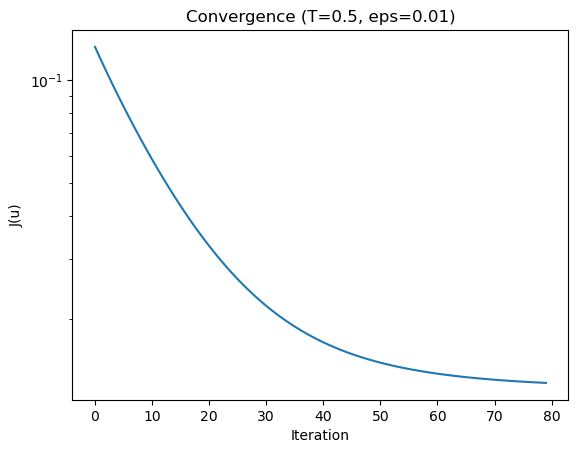

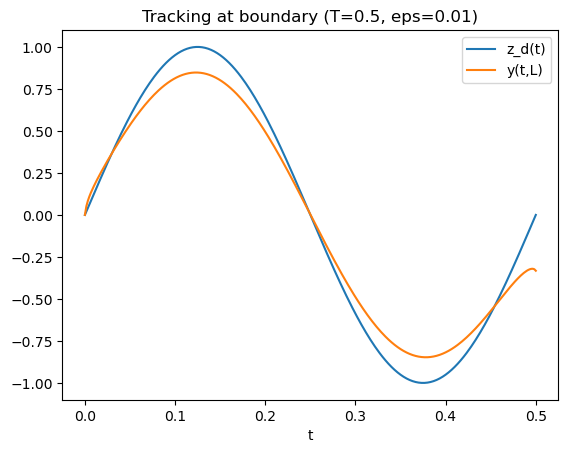

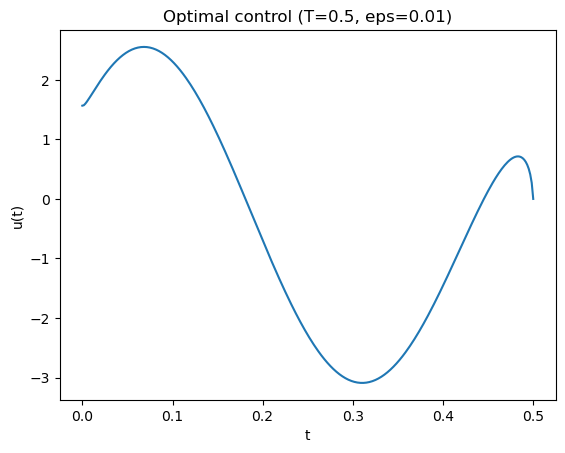

Iter   0 | J = 2.500e-01 | ||grad|| = 5.813e+00
Iter   1 | J = 2.228e-01 | ||grad|| = 5.438e+00
Iter   2 | J = 1.990e-01 | ||grad|| = 5.093e+00
Iter   3 | J = 1.781e-01 | ||grad|| = 4.775e+00
Iter   4 | J = 1.598e-01 | ||grad|| = 4.480e+00
Iter   5 | J = 1.436e-01 | ||grad|| = 4.207e+00
Iter   6 | J = 1.294e-01 | ||grad|| = 3.953e+00
Iter   7 | J = 1.168e-01 | ||grad|| = 3.717e+00
Iter   8 | J = 1.057e-01 | ||grad|| = 3.498e+00
Iter   9 | J = 9.582e-02 | ||grad|| = 3.292e+00
Iter  10 | J = 8.709e-02 | ||grad|| = 3.101e+00
Iter  11 | J = 7.934e-02 | ||grad|| = 2.922e+00
Iter  12 | J = 7.246e-02 | ||grad|| = 2.754e+00
Iter  13 | J = 6.635e-02 | ||grad|| = 2.598e+00
Iter  14 | J = 6.091e-02 | ||grad|| = 2.451e+00
Iter  15 | J = 5.607e-02 | ||grad|| = 2.313e+00
Iter  16 | J = 5.176e-02 | ||grad|| = 2.184e+00
Iter  17 | J = 4.792e-02 | ||grad|| = 2.063e+00
Iter  18 | J = 4.448e-02 | ||grad|| = 1.950e+00
Iter  19 | J = 4.142e-02 | ||grad|| = 1.844e+00
Iter  20 | J = 3.867e-02 | ||grad|| = 1.

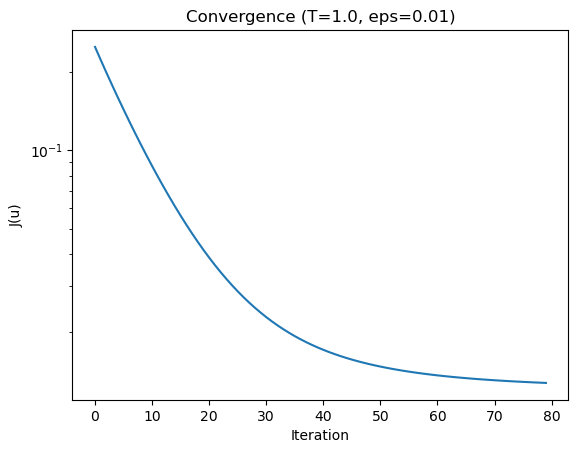

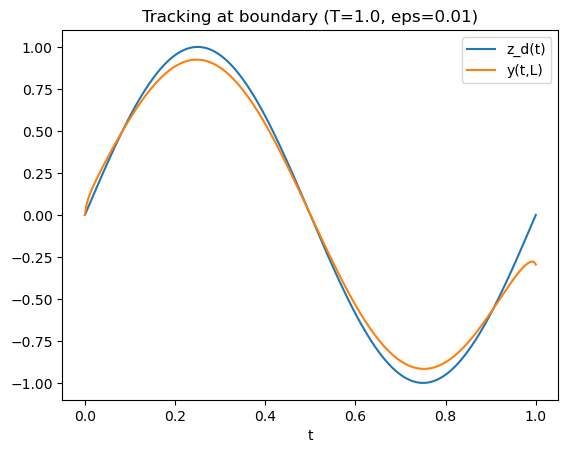

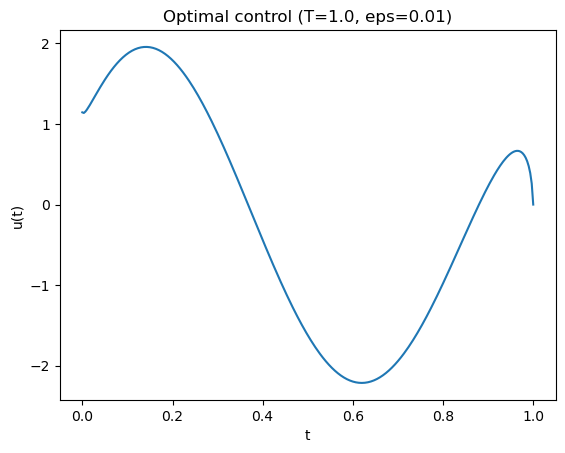

In [29]:
# --- Case B: test T ---
eps = 1e-2
for T, alpha in [(0.2, 0.5), (0.5, 0.4), (1.0, 0.25)]:
    t, zd, u, yL, Jhist = run_experiment(L, T, Nx, Nt, eps, zd_smooth, alpha, max_iter=80)
    plot_result(t, zd, u, yL, Jhist, title=f"(T={T}, eps={eps})")

Iter   0 | J = 0.000e+00 | ||grad|| = 0.000e+00


/var/folders/53/dz3rwmgx46b2y6jyc15z61r00000gn/T/ipykernel_23152/3698043319.py:21: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


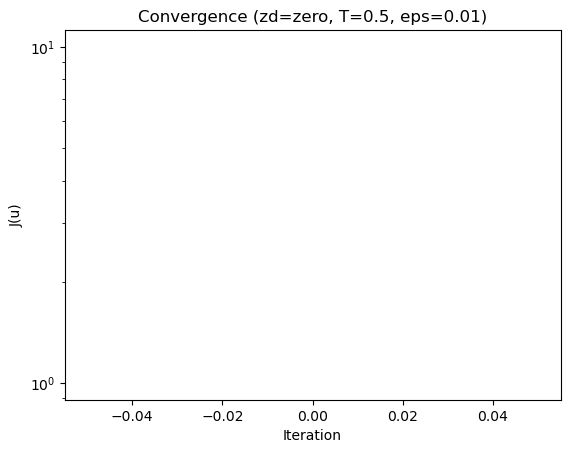

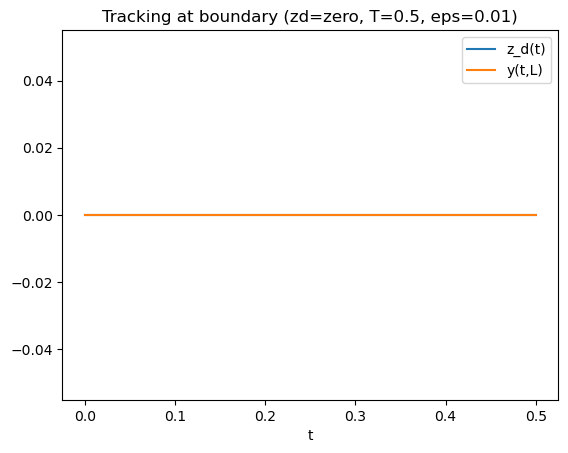

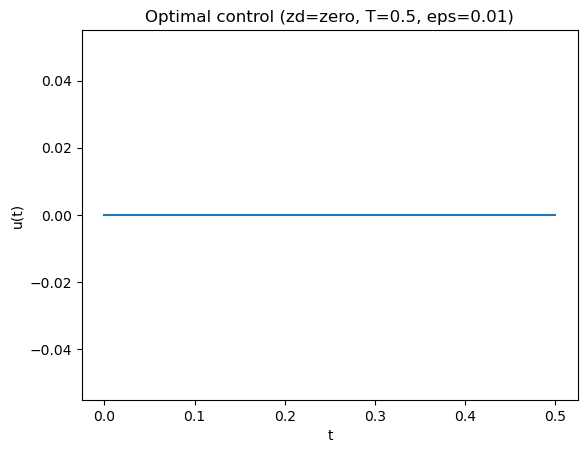

Iter   0 | J = 1.250e-01 | ||grad|| = 3.952e+00
Iter   1 | J = 1.149e-01 | ||grad|| = 3.741e+00
Iter   2 | J = 1.058e-01 | ||grad|| = 3.546e+00
Iter   3 | J = 9.767e-02 | ||grad|| = 3.367e+00
Iter   4 | J = 9.031e-02 | ||grad|| = 3.201e+00
Iter   5 | J = 8.367e-02 | ||grad|| = 3.046e+00
Iter   6 | J = 7.765e-02 | ||grad|| = 2.901e+00
Iter   7 | J = 7.219e-02 | ||grad|| = 2.766e+00
Iter   8 | J = 6.723e-02 | ||grad|| = 2.638e+00
Iter   9 | J = 6.271e-02 | ||grad|| = 2.518e+00
Iter  10 | J = 5.859e-02 | ||grad|| = 2.404e+00
Iter  11 | J = 5.484e-02 | ||grad|| = 2.297e+00
Iter  12 | J = 5.142e-02 | ||grad|| = 2.195e+00
Iter  13 | J = 4.829e-02 | ||grad|| = 2.098e+00
Iter  14 | J = 4.543e-02 | ||grad|| = 2.007e+00
Iter  15 | J = 4.282e-02 | ||grad|| = 1.919e+00
Iter  16 | J = 4.043e-02 | ||grad|| = 1.837e+00
Iter  17 | J = 3.824e-02 | ||grad|| = 1.758e+00
Iter  18 | J = 3.623e-02 | ||grad|| = 1.682e+00
Iter  19 | J = 3.439e-02 | ||grad|| = 1.611e+00
Iter  20 | J = 3.271e-02 | ||grad|| = 1.

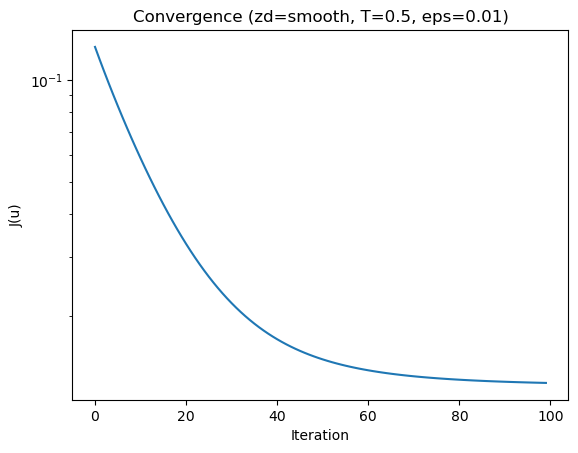

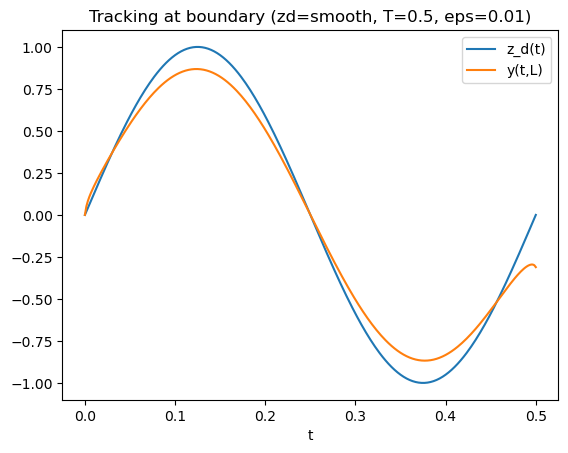

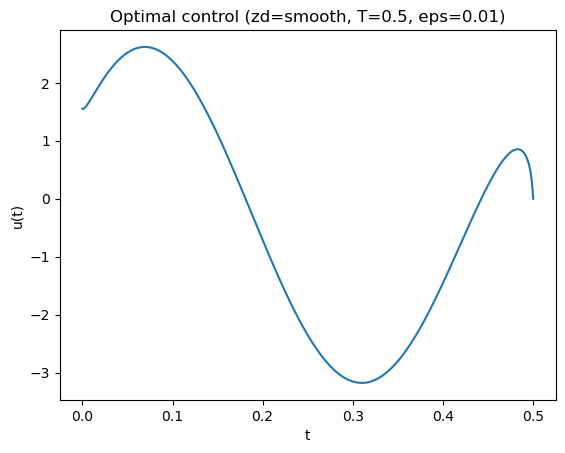

Iter   0 | J = 1.250e-01 | ||grad|| = 1.555e+00
Iter   1 | J = 1.240e-01 | ||grad|| = 1.540e+00
Iter   2 | J = 1.230e-01 | ||grad|| = 1.527e+00
Iter   3 | J = 1.221e-01 | ||grad|| = 1.514e+00
Iter   4 | J = 1.211e-01 | ||grad|| = 1.501e+00
Iter   5 | J = 1.202e-01 | ||grad|| = 1.489e+00
Iter   6 | J = 1.193e-01 | ||grad|| = 1.477e+00
Iter   7 | J = 1.184e-01 | ||grad|| = 1.466e+00
Iter   8 | J = 1.175e-01 | ||grad|| = 1.454e+00
Iter   9 | J = 1.166e-01 | ||grad|| = 1.444e+00
Iter  10 | J = 1.157e-01 | ||grad|| = 1.433e+00
Iter  11 | J = 1.149e-01 | ||grad|| = 1.423e+00
Iter  12 | J = 1.140e-01 | ||grad|| = 1.412e+00
Iter  13 | J = 1.132e-01 | ||grad|| = 1.402e+00
Iter  14 | J = 1.124e-01 | ||grad|| = 1.392e+00
Iter  15 | J = 1.116e-01 | ||grad|| = 1.383e+00
Iter  16 | J = 1.108e-01 | ||grad|| = 1.373e+00
Iter  17 | J = 1.100e-01 | ||grad|| = 1.363e+00
Iter  18 | J = 1.093e-01 | ||grad|| = 1.354e+00
Iter  19 | J = 1.085e-01 | ||grad|| = 1.345e+00
Iter  20 | J = 1.078e-01 | ||grad|| = 1.

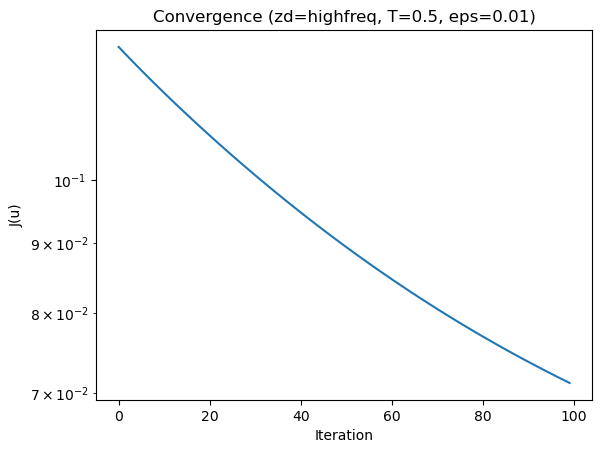

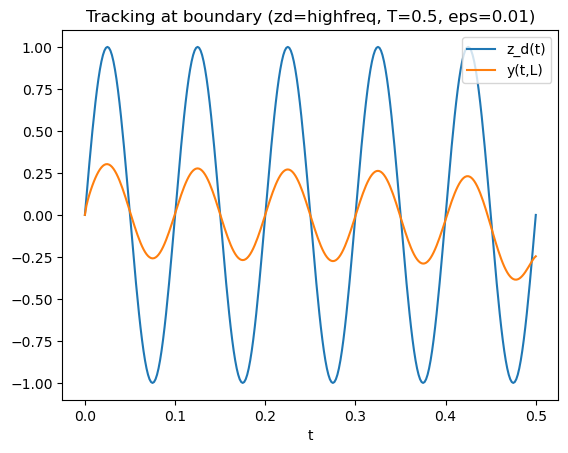

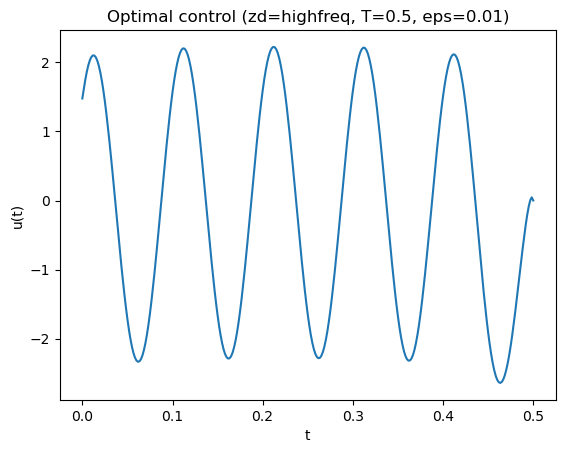

In [30]:
# --- Case C: test difficulty of zd ---
T = 0.5
eps = 1e-2
for zd_fun, name, alpha in [(zd_zero, "zero", 0.8),
                            (zd_smooth, "smooth", 0.4),
                            (zd_highfreq, "highfreq", 0.25)]:
    t, zd, u, yL, Jhist = run_experiment(L, T, Nx, Nt, eps, zd_fun, alpha, max_iter=100)
    plot_result(t, zd, u, yL, Jhist, title=f"(zd={name}, T={T}, eps={eps})")

Les résultats numériques montrent que le paramètre $\varepsilon$, le temps final (T) et la régularité de la cible $z_d$ influencent fortement la solution optimale.

Lorsque $\varepsilon$ diminue, le contrôle optimal devient plus intense et le problème plus raide numériquement.

Un temps final plus long améliore le suivi de la cible, tandis que les cibles à haute fréquence sont plus difficiles à atteindre en raison de l’effet régularisant de l’équation de la chaleur.